In [1]:
# %% [markdown]
# ## 1. Setup and Imports

# %%
import pandas as pd
import numpy as np
import networkx as nx
import pickle
from pathlib import Path
from collections import defaultdict, Counter
import json
import warnings
warnings.filterwarnings('ignore')

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [2]:
# Configuration
FEATURES_DIR = "extracted_features"
GRAPHS_DIR = "constructed_graphs"
OUTPUT_DIR = "clustering_results"

# Create output directory
Path(OUTPUT_DIR).mkdir(exist_ok=True)

print("Loading data...")

features_df = pd.read_csv(f'{FEATURES_DIR}/node_features.csv')
print(f"Loaded {len(features_df)} node features")
print(f"Columns: {features_df.columns.tolist()[:10]}...")

# Display sample
features_df.head()

# %%
# Load feature matrix and labels
X = np.load(f'{FEATURES_DIR}/node_X.npy')
y = np.load(f'{FEATURES_DIR}/node_y.npy')
addresses = np.load(f'{FEATURES_DIR}/node_addresses.npy', allow_pickle=True)

with open(f'{FEATURES_DIR}/node_feature_names.json', 'r') as f:
    feature_names = json.load(f)

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"\nClass distribution:")
print(f"  Hackers: {y.sum()}")
print(f"  Normal: {len(y) - y.sum()}")
print(f"  Hacker ratio: {y.mean():.4f}")

# %%
# Load graph
with open(f'{GRAPHS_DIR}/static_graph.gpickle', 'rb') as f:
    G = pickle.load(f)

print(f"Graph loaded:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Density: {nx.density(G):.6f}")


Loading data...
Loaded 26951 node features
Columns: ['address', 'node_type', 'incident', 'label', 'in_degree', 'out_degree', 'total_degree', 'degree_ratio', 'total_in_value', 'total_out_value']...
Feature matrix shape: (26951, 53)
Number of features: 53

Class distribution:
  Hackers: 140
  Normal: 26811
  Hacker ratio: 0.0052
Graph loaded:
  Nodes: 26951
  Edges: 27553
  Density: 0.000038


Feature Statistics:


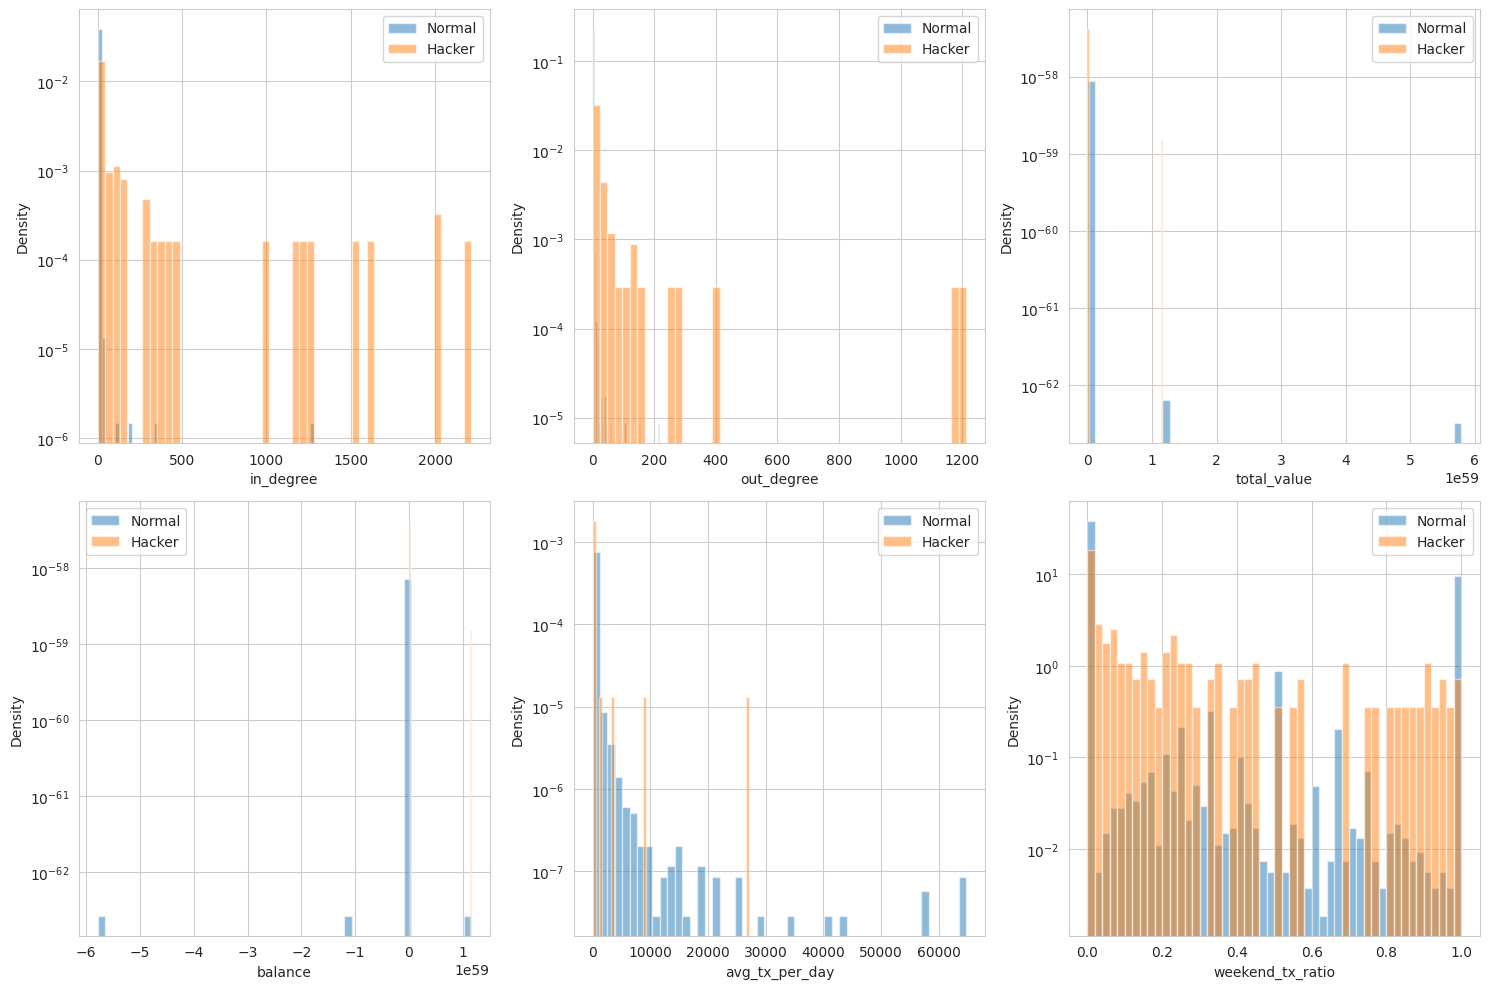

✓ Feature distributions plotted


In [3]:

# Feature statistics
feature_stats = features_df[['in_degree', 'out_degree', 'total_value', 'balance', 
                              'avg_tx_per_day', 'weekend_tx_ratio', 'is_potential_mixer']].describe()
print("Feature Statistics:")
feature_stats

# %%
# Compare hacker vs normal features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

key_features = ['in_degree', 'out_degree', 'total_value', 'balance', 'avg_tx_per_day', 'weekend_tx_ratio']

for idx, feat in enumerate(key_features):
    ax = axes[idx]
    
    hacker_data = features_df[features_df['is_hacker'] == 1][feat]
    normal_data = features_df[features_df['is_hacker'] == 0][feat]
    
    ax.hist(normal_data, bins=50, alpha=0.5, label='Normal', density=True)
    ax.hist(hacker_data, bins=50, alpha=0.5, label='Hacker', density=True)
    ax.set_xlabel(feat)
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_yscale('log')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature distributions plotted")

Features standardized


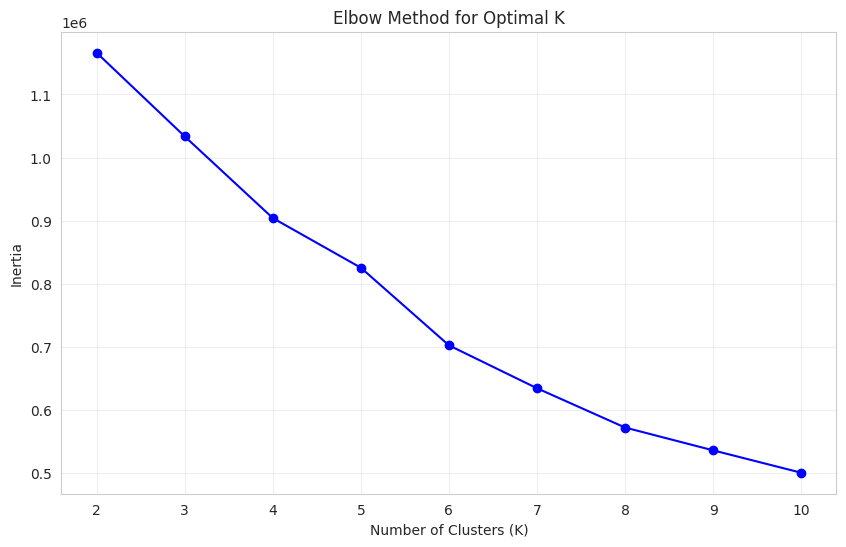

✓ Elbow plot generated
K-Means clustering completed with K=5
Cluster sizes: [26932     1     2     6    10]

K-Means Cluster Analysis:
          size  num_hackers  hacker_ratio
cluster                                  
2            2            2        1.0000
4           10            9        0.9000
3            6            5        0.8333
0        26932          124        0.0046
1            1            0        0.0000

🚨 Found 3 suspicious clusters (>30% hackers)
         size  num_hackers  hacker_ratio
cluster                                 
2           2            2        1.0000
4          10            9        0.9000
3           6            5        0.8333


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features standardized")

# %%
# Elbow method to find optimal K
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True, alpha=0.3)
plt.savefig(f'{OUTPUT_DIR}/kmeans_elbow.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Elbow plot generated")

# %%
# K-Means with optimal K
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

print(f"K-Means clustering completed with K={optimal_k}")
print(f"Cluster sizes: {np.bincount(kmeans_labels)}")

# %%
# Analyze K-Means clusters
kmeans_df = pd.DataFrame({
    'address': addresses,
    'cluster': kmeans_labels,
    'is_hacker': y
})

cluster_stats = kmeans_df.groupby('cluster').agg({
    'is_hacker': ['count', 'sum', 'mean']
}).round(4)

cluster_stats.columns = ['size', 'num_hackers', 'hacker_ratio']
cluster_stats = cluster_stats.sort_values('hacker_ratio', ascending=False)

print("\nK-Means Cluster Analysis:")
print(cluster_stats)

# Highlight suspicious clusters
suspicious_clusters = cluster_stats[cluster_stats['hacker_ratio'] > 0.3]
print(f"\n🚨 Found {len(suspicious_clusters)} suspicious clusters (>30% hackers)")
print(suspicious_clusters)


In [5]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN clustering completed")
print(f"  Number of clusters: {n_clusters}")
print(f"  Noise points: {n_noise}")

# %%
# Analyze DBSCAN clusters (excluding noise)
dbscan_df = pd.DataFrame({
    'address': addresses,
    'cluster': dbscan_labels,
    'is_hacker': y
})

# Filter out noise
dbscan_clusters = dbscan_df[dbscan_df['cluster'] != -1]

dbscan_stats = dbscan_clusters.groupby('cluster').agg({
    'is_hacker': ['count', 'sum', 'mean']
}).round(4)

dbscan_stats.columns = ['size', 'num_hackers', 'hacker_ratio']
dbscan_stats = dbscan_stats.sort_values('hacker_ratio', ascending=False)

print("\nDBSCAN Cluster Analysis (top 10):")
print(dbscan_stats.head(10))

# Suspicious clusters
suspicious_dbscan = dbscan_stats[dbscan_stats['hacker_ratio'] > 0.3]
print(f"\n🚨 Found {len(suspicious_dbscan)} suspicious DBSCAN clusters")


DBSCAN clustering completed
  Number of clusters: 49
  Noise points: 1644

DBSCAN Cluster Analysis (top 10):
          size  num_hackers  hacker_ratio
cluster                                  
2         3541           32         0.009
0        14102            0         0.000
37           6            0         0.000
27          21            0         0.000
28          11            0         0.000
29          18            0         0.000
30          47            0         0.000
31          26            0         0.000
32           7            0         0.000
33          34            0         0.000

🚨 Found 0 suspicious DBSCAN clusters


In [6]:
hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

print(f"Hierarchical clustering completed")
print(f"Cluster sizes: {np.bincount(hierarchical_labels)}")

# %%
# Analyze Hierarchical clusters
hierarchical_df = pd.DataFrame({
    'address': addresses,
    'cluster': hierarchical_labels,
    'is_hacker': y
})

hierarchical_stats = hierarchical_df.groupby('cluster').agg({
    'is_hacker': ['count', 'sum', 'mean']
}).round(4)

hierarchical_stats.columns = ['size', 'num_hackers', 'hacker_ratio']
hierarchical_stats = hierarchical_stats.sort_values('hacker_ratio', ascending=False)

print("\nHierarchical Cluster Analysis:")
print(hierarchical_stats)


Hierarchical clustering completed
Cluster sizes: [26933     2     6     2     8]

Hierarchical Cluster Analysis:
          size  num_hackers  hacker_ratio
cluster                                  
3            2            2        1.0000
4            8            7        0.8750
2            6            5        0.8333
0        26933          126        0.0047
1            2            0        0.0000


In [7]:
G_undirected = G.to_undirected()

print(f"Undirected graph: {G_undirected.number_of_nodes()} nodes, {G_undirected.number_of_edges()} edges")

# %%
# Community detection using Louvain or Greedy Modularity
try:
    # Try python-louvain
    import community.community_louvain as community_louvain
    communities = community_louvain.best_partition(G_undirected)
    method = "Louvain"
except (ImportError, AttributeError):
    try:
        from community import best_partition
        communities = best_partition(G_undirected)
        method = "Louvain"
    except (ImportError, AttributeError):
        # Fallback to NetworkX greedy modularity
        from networkx.algorithms import community
        communities_gen = community.greedy_modularity_communities(G_undirected)
        communities = {}
        for idx, comm in enumerate(communities_gen):
            for node in comm:
                communities[node] = idx
        method = "Greedy Modularity"

n_communities = len(set(communities.values()))
print(f"{method}: Found {n_communities} communities")

# %%
# Map communities to addresses
community_labels = np.array([communities.get(addr, -1) for addr in addresses])

# Analyze communities
community_df = pd.DataFrame({
    'address': addresses,
    'community': community_labels,
    'is_hacker': y
})

community_stats = community_df[community_df['community'] != -1].groupby('community').agg({
    'is_hacker': ['count', 'sum', 'mean']
}).round(4)

community_stats.columns = ['size', 'num_hackers', 'hacker_ratio']
community_stats = community_stats.sort_values('hacker_ratio', ascending=False)

print("\nCommunity Detection Analysis (top 10):")
print(community_stats.head(10))

# Suspicious communities
suspicious_communities = community_stats[community_stats['hacker_ratio'] > 0.3]
print(f"\n🚨 Found {len(suspicious_communities)} suspicious communities")


Undirected graph: 26951 nodes, 25292 edges
Louvain: Found 3570 communities

Community Detection Analysis (top 10):
           size  num_hackers  hacker_ratio
community                                 
1215          1            1           1.0
425           1            1           1.0
1429          1            1           1.0
704           1            1           1.0
705           1            1           1.0
706           1            1           1.0
1423          1            1           1.0
76            1            1           1.0
59            1            1           1.0
628           1            1           1.0

🚨 Found 32 suspicious communities


PCA variance explained: [0.24623959 0.10381459]
Total variance: 0.3501


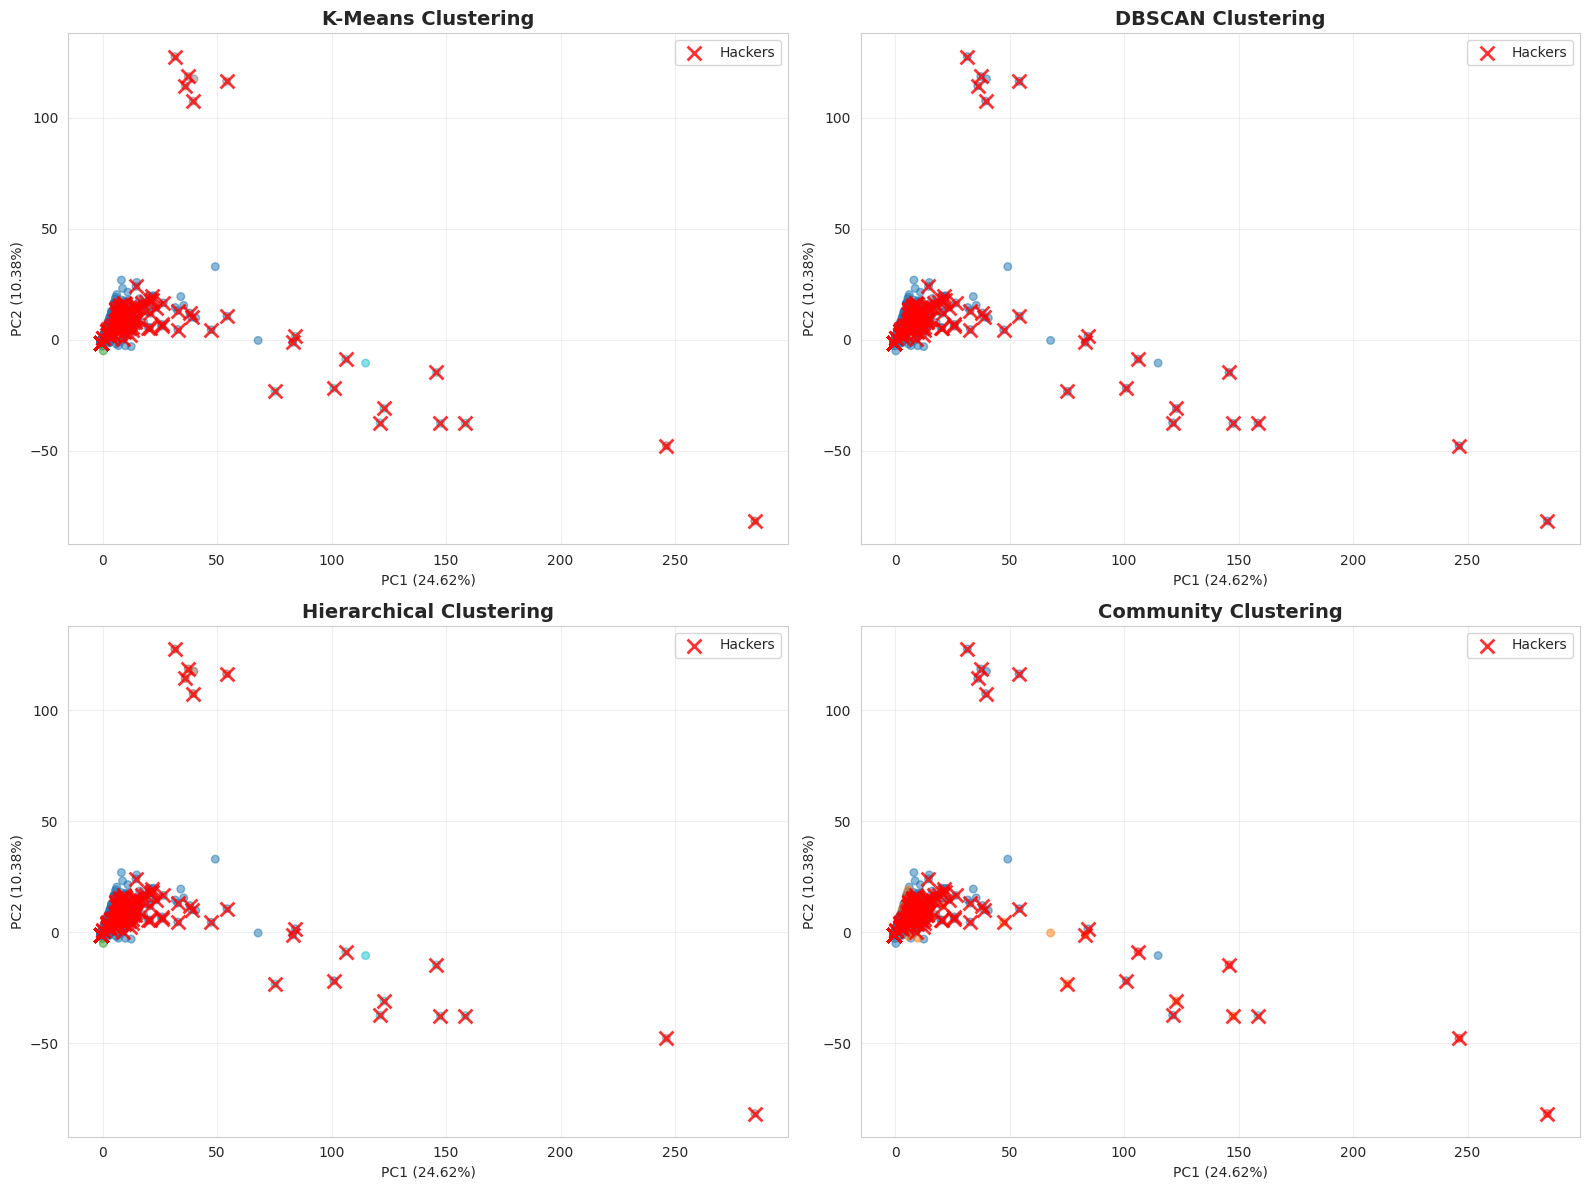

✓ Cluster visualizations generated


In [8]:
# %%
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA variance explained: {pca.explained_variance_ratio_}")
print(f"Total variance: {pca.explained_variance_ratio_.sum():.4f}")

# %%
# Visualize all clustering methods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

clustering_methods = [
    ('K-Means', kmeans_labels),
    ('DBSCAN', dbscan_labels),
    ('Hierarchical', hierarchical_labels),
    ('Community', community_labels)
]

for idx, (method, labels) in enumerate(clustering_methods):
    ax = axes[idx // 2, idx % 2]
    
    # Plot clusters
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                        c=labels, cmap='tab10', 
                        alpha=0.5, s=30)
    
    # Highlight hackers
    hacker_mask = y == 1
    ax.scatter(X_pca[hacker_mask, 0], X_pca[hacker_mask, 1],
              c='red', marker='x', s=100, linewidth=2, label='Hackers', alpha=0.8)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax.set_title(f'{method} Clustering', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/all_clustering_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Cluster visualizations generated")


In [9]:
peeling_chains = []

for node in G.nodes():
    out_neighbors = list(G.successors(node))
    
    if len(out_neighbors) > 5:
        out_edges = [(node, v, G[node][v]) for v in out_neighbors]
        values = [data.get('value', 0) for _, _, data in out_edges]
        
        if len(values) > 0:
            median_val = np.median(values)
            small_outputs = sum(1 for v in values if v < median_val)
            
            if small_outputs / len(values) > 0.6:
                peeling_chains.append({
                    'address': node,
                    'num_outputs': len(out_neighbors),
                    'small_output_ratio': small_outputs / len(values)
                })

print(f"🔍 Found {len(peeling_chains)} peeling chain patterns")

# Display top 10
if peeling_chains:
    peeling_df = pd.DataFrame(peeling_chains).sort_values('num_outputs', ascending=False)
    print("\nTop 10 Peeling Chains:")
    print(peeling_df.head(10))

# %%
# Detect mixing patterns
mixing_patterns = []

for node in G.nodes():
    in_degree = G.in_degree(node)
    out_degree = G.out_degree(node)
    
    if in_degree > 10 and out_degree > 10:
        mixing_patterns.append({
            'address': node,
            'in_degree': in_degree,
            'out_degree': out_degree,
            'total_degree': in_degree + out_degree
        })

print(f"🔍 Found {len(mixing_patterns)} potential mixing patterns")

# Display top 10
if mixing_patterns:
    mixing_df = pd.DataFrame(mixing_patterns).sort_values('total_degree', ascending=False)
    print("\nTop 10 Mixing Patterns:")
    print(mixing_df.head(10))

# %%
# Detect fan-out patterns
fan_out_patterns = []

for node in G.nodes():
    in_degree = G.in_degree(node)
    out_degree = G.out_degree(node)
    
    if in_degree <= 2 and out_degree > 10:
        fan_out_patterns.append({
            'address': node,
            'in_degree': in_degree,
            'out_degree': out_degree
        })

print(f"🔍 Found {len(fan_out_patterns)} fan-out distribution patterns")

# Display top 10
if fan_out_patterns:
    fanout_df = pd.DataFrame(fan_out_patterns).sort_values('out_degree', ascending=False)
    print("\nTop 10 Fan-out Patterns:")
    print(fanout_df.head(10))


🔍 Found 0 peeling chain patterns
🔍 Found 52 potential mixing patterns

Top 10 Mixing Patterns:
                                       address  in_degree  out_degree  \
47  0x35ffd6e268610e764ff6944d07760d0efe5e40e5       1231        1168   
41  0x5d3a536e4d6dbd6114cc1ead35777bab948e3643        999        1212   
43  0xf4a2eff88a408ff4c4550148151c33c93442619e       1545         248   
21  0xa7f72bf63edeca25636f0b13ec5135296ca2ebb2       1604          38   
44  0xc8a65fadf0e0ddaf421f28feab69bf6e2e589963       1277          31   
13  0xc433d50dd0614c81ee314289ec82aa63710d25e8        365         393   
38  0x9fb9a33956351cf4fa040f65a13b835a3c8764e3        324         290   
25  0x59abf3837fa962d6853b4cc0a19513aa031fd32b        471         126   
23  0xb66cd966670d962c227b3eaba30a872dbfb995db        412          35   
24  0x098b716b8aaf21512996dc57eb0615e2383e2f96        197         216   

    total_degree  
47          2399  
41          2211  
43          1793  
21          1642  
44    

In [15]:
print("Finding potential laundering rings...")

try:
    # Remove self-loops first
    G_no_self = G.copy()
    G_no_self.remove_edges_from(nx.selfloop_edges(G_no_self))
    
    print(f"Removed {G.number_of_edges() - G_no_self.number_of_edges()} self-loops")
    
    k_cores = nx.k_core(G_no_self, k=3)
    
    if k_cores.number_of_nodes() > 0:
        components = list(nx.weakly_connected_components(k_cores))
        
        rings = []
        for comp in components:
            if len(comp) >= 3:
                comp_addresses = list(comp)
                comp_labels = [y[list(addresses).index(addr)] 
                             for addr in comp_addresses 
                             if addr in addresses]
                
                if sum(comp_labels) > 0:
                    rings.append({
                        'size': len(comp),
                        'num_hackers': sum(comp_labels),
                        'hacker_ratio': np.mean(comp_labels) if comp_labels else 0,
                        'addresses': comp_addresses[:5]  # Sample
                    })
        
        print(f"🔍 Found {len(rings)} potential laundering rings")
        
        if rings:
            rings_df = pd.DataFrame(rings).sort_values('hacker_ratio', ascending=False)
            print("\nTop Laundering Rings:")
            print(rings_df.head(10))
    else:
        print("No k-cores found with k=3")
except Exception as e:
    print(f"Error in ring detection: {e}")


Finding potential laundering rings...
Removed 26 self-loops
🔍 Found 1 potential laundering rings

Top Laundering Rings:
   size  num_hackers  hacker_ratio  \
0   448           96      0.214286   

                                           addresses  
0  [0x905b63fff465b9ffbf41dea908ceb12478ec7601, 0...  


In [16]:
kmeans_df.to_csv(f'{OUTPUT_DIR}/kmeans_clusters.csv', index=False)
dbscan_df.to_csv(f'{OUTPUT_DIR}/dbscan_clusters.csv', index=False)
hierarchical_df.to_csv(f'{OUTPUT_DIR}/hierarchical_clusters.csv', index=False)
community_df.to_csv(f'{OUTPUT_DIR}/community_clusters.csv', index=False)

print("✓ Cluster assignments saved")

# %%
# Save pattern detection results
patterns = {
    'peeling_chains': peeling_chains,
    'mixing_patterns': mixing_patterns,
    'fan_out_patterns': fan_out_patterns
}

with open(f'{OUTPUT_DIR}/laundering_patterns.json', 'w') as f:
    json.dump(patterns, f, indent=2)

print("✓ Pattern detection results saved")


✓ Cluster assignments saved
✓ Pattern detection results saved


In [17]:
# %%
# Compare clustering methods
comparison = pd.DataFrame([
    {
        'Method': 'K-Means',
        'Num Clusters': len(set(kmeans_labels)),
        'Suspicious Clusters': len(cluster_stats[cluster_stats['hacker_ratio'] > 0.3]),
        'Avg Cluster Size': cluster_stats['size'].mean(),
        'Max Hacker Ratio': cluster_stats['hacker_ratio'].max()
    },
    {
        'Method': 'DBSCAN',
        'Num Clusters': n_clusters,
        'Suspicious Clusters': len(dbscan_stats[dbscan_stats['hacker_ratio'] > 0.3]),
        'Avg Cluster Size': dbscan_stats['size'].mean(),
        'Max Hacker Ratio': dbscan_stats['hacker_ratio'].max()
    },
    {
        'Method': 'Hierarchical',
        'Num Clusters': len(set(hierarchical_labels)),
        'Suspicious Clusters': len(hierarchical_stats[hierarchical_stats['hacker_ratio'] > 0.3]),
        'Avg Cluster Size': hierarchical_stats['size'].mean(),
        'Max Hacker Ratio': hierarchical_stats['hacker_ratio'].max()
    },
    {
        'Method': 'Community',
        'Num Clusters': n_communities,
        'Suspicious Clusters': len(community_stats[community_stats['hacker_ratio'] > 0.3]),
        'Avg Cluster Size': community_stats['size'].mean(),
        'Max Hacker Ratio': community_stats['hacker_ratio'].max()
    }
])

print("\n" + "="*80)
print("CLUSTERING METHODS COMPARISON")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)

comparison.to_csv(f'{OUTPUT_DIR}/clustering_comparison.csv', index=False)



CLUSTERING METHODS COMPARISON
      Method  Num Clusters  Suspicious Clusters  Avg Cluster Size  Max Hacker Ratio
     K-Means             5                    3       5390.200000             1.000
      DBSCAN            49                    0        516.469388             0.009
Hierarchical             5                    3       5390.200000             1.000
   Community          3570                   32          7.549300             1.000


In [18]:
# %%
print("\n" + "="*80)
print("CLUSTERING & PATTERN DISCOVERY ANALYSIS COMPLETE")
print("="*80)
print("\nKey Findings:")
print(f"  - Total nodes analyzed: {len(addresses):,}")
print(f"  - Known hackers: {int(y.sum()):,}")
print(f"  - Suspicious clusters found: {len(suspicious_clusters) + len(suspicious_dbscan) + len(suspicious_communities)}")
print(f"  - Peeling chains detected: {len(peeling_chains)}")
print(f"  - Mixing patterns detected: {len(mixing_patterns)}")
print(f"  - Fan-out patterns detected: {len(fan_out_patterns)}")
print("\n" + "="*80)
print(f"\n✓ All results saved to: {OUTPUT_DIR}/")
print("="*80)


CLUSTERING & PATTERN DISCOVERY ANALYSIS COMPLETE

Key Findings:
  - Total nodes analyzed: 26,951
  - Known hackers: 140
  - Suspicious clusters found: 35
  - Peeling chains detected: 0
  - Mixing patterns detected: 52
  - Fan-out patterns detected: 7


✓ All results saved to: clustering_results/
